Importing modules + training data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing, linear_model, model_selection, metrics, neighbors, ensemble
import numpy as np

# your files might be in "Shared with me" instead of "My Drive", or you could just manually upload to the Colab and remove the "drive/My Drive/STAT441 Kaggle/" part entirely
df_ed_train = pd.read_csv("./module_Education_train_set.csv")
df_hh_train = pd.read_csv("./module_HouseholdInfo_train_set.csv")
y_train = pd.read_csv("./module_SubjectivePoverty_train_set.csv")

df_ed_test = pd.read_csv("./module_Education_test_set.csv")
df_hh_test = pd.read_csv("./module_HouseholdInfo_test_set.csv")

Combining DFs

In [3]:
#adding the 'psu_hh_idcode' column for future merging
df_ed_train['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_ed_train.iterrows()]
df_ed_train.drop(['hh', 'idcode'], axis=1, inplace=True)

df_hh_train['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_hh_train.iterrows()]
df_hh_train.drop(['hh', 'idcode'], axis=1, inplace=True)

df_ed_test['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_ed_test.iterrows()]
df_ed_test.drop(['hh', 'idcode'], axis=1, inplace=True)


df_hh_test['psu_hh_idcode'] = ['_'.join([str(int(row['psu'])),str(int(row['hh'])),str(int(row['idcode']))]) for index, row in df_hh_test.iterrows()]
df_hh_test.drop(['hh', 'idcode'], axis=1, inplace=True)

# combining the subjective_poverty_n columns into a single column
y_train = y_train[y_train['psu_hh_idcode'].isin(df_ed_train['psu_hh_idcode'])]
sp_onehot = y_train.drop(columns=['psu_hh_idcode'])
y_train['subjective_poverty'] = pd.from_dummies(sp_onehot)
y_train['subjective_poverty'] = [int(x[19:]) for x in y_train['subjective_poverty']]
y_train.drop(columns=['subjective_poverty_' + str(i) for i in range(1,11)], inplace=True)

df_ed_train.set_index('psu_hh_idcode', inplace=True)
df_hh_train.set_index('psu_hh_idcode', inplace=True)
df_ed_test.set_index('psu_hh_idcode', inplace=True)
df_hh_test.set_index('psu_hh_idcode', inplace=True)

y_train.set_index('psu_hh_idcode', inplace=True)

#MAYBE REMOVE THIS PART:
# All other columns in the education test set are almost 99% NA
# Theoretically including all the rest of the columns should only give at most a score improvement of ~0.023
# since it only applies to 1% of the training data (and just giving every option a 0.1 chance is a log loss of 2.3)
##### df_ed_train = df_ed_train[['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q11', 'Q14', 'Q17', 'Q18', 'Q19']]
df_ed_train['set'] = 'train'
##### df_ed_test = df_ed_test[['q01', 'q02', 'q03', 'q04', 'q05', 'q06', 'q07', 'Q08', 'Q11', 'Q14', 'Q17', 'Q18', 'Q19']]
df_ed_test['set'] = 'test'

# combining training and test sets
df_ed = pd.concat([df_ed_train, df_ed_test])
df_hh = pd.concat([df_hh_train, df_hh_test])

df = df_hh.join(df_ed, lsuffix="_hh", how='inner')


Filling in NAs

In [4]:
###df['q07'].fillna(0) # q07 in education is NA => never went to school => 0 years of preschool


def highest_education(index):
  row = df_ed.loc[index]
  if row['q03'] == 2 or row['q06'] == 0:
    return 1 # no education
  elif row['q06'] == 1:
    return 2 # primary 4/5
  elif row['q06'] == 2 and row['q04'] == 1:
    return 3 # primary 7/8/9
  elif row['q04'] == 2 and row['q06'] < 3:
    return 4 # some secondary
  elif row['q06'] == 3 and row['q04'] == 2:
    return 5 # finished secondary
  elif row['q06'] < 4 and row['q04'] in [3,4,5]:
    return 6 # some vocational (pretty sure "Technicum" is  a type of vocational)
  elif row['q06'] in [4,5,6] and row['q04'] < 6:
    return 7 # finished vocational
  elif row['q06'] < 7 and row['q04'] >= 6:
    return 8 # some university
  elif row['q06'] in [7,8,9]:
    return 9 # finished university
  else:
    return 10 # Post university



for index, row in df.iterrows():
  if row['q11'] == 1:
    mother = '_'.join(index.split('_')[:-1] + [str(int(row['q12']))])
    if mother in df_ed.index:
        row['q13'] = highest_education(mother)
    elif mother in df_ed.index:
        row['q13'] = highest_education(mother)
    row['q14'] = 1
    if mother in df_hh.index:
        row['q16'] = df_hh.loc[mother]['q05y']

  if row['q17'] == 1:
    father = '_'.join(index.split('_')[:-1] + [str(int(row['q18']))])
    if father in df_ed.index:
        row['q19'] = highest_education(father)
    row['q20'] = 1
    if father in df_hh.index:
        row['q22'] = df_hh.loc[father]['q05y']

df.drop(columns=['q12', 'q18'], inplace=True)


Comparing distributions

In [5]:
# First analyze NA distributions across all columns
print("Initial NA Percentages:")
for col in df.columns:
    if col not in ['set', 'subjective_poverty']:  # Skip these metadata columns
        train_na = df[df['set'] == 'train'][col].isna().mean()
        test_na = df[df['set'] == 'test'][col].isna().mean()
        
        # Only print if there are any NAs in either set
        if train_na > 0 or test_na > 0:
            print(f"\n{col}:")
            print(f"Train NA%: {train_na:.2%}")
            print(f"Test NA%: {test_na:.2%}")
            
            # Also show value distribution for columns with NAs
            print("\nValue distribution (excluding NAs):")
            print(df[col].value_counts(normalize=True).head())


Initial NA Percentages:

q06_hh:
Train NA%: 8.66%
Test NA%: 0.00%

Value distribution (excluding NAs):
q06_hh
1.0    0.599294
5.0    0.333043
4.0    0.056562
2.0    0.008441
3.0    0.002661
Name: proportion, dtype: float64

q07_hh:
Train NA%: 45.78%
Test NA%: 13.19%

Value distribution (excluding NAs):
q07_hh
1.0    0.967308
2.0    0.032692
Name: proportion, dtype: float64

q08:
Train NA%: 47.51%
Test NA%: 16.79%

Value distribution (excluding NAs):
q08
2.0    0.443400
1.0    0.432756
3.0    0.053997
4.0    0.042654
5.0    0.010566
Name: proportion, dtype: float64

q13:
Train NA%: 45.27%
Test NA%: 8.02%

Value distribution (excluding NAs):
q13
2.0    0.377317
1.0    0.338621
3.0    0.208970
5.0    0.033062
4.0    0.017717
Name: proportion, dtype: float64

q14:
Train NA%: 45.27%
Test NA%: 8.02%

Value distribution (excluding NAs):
q14
2.0    0.524166
1.0    0.475834
Name: proportion, dtype: float64

q15:
Train NA%: 71.52%
Test NA%: 48.35%

Value distribution (excluding NAs):
q15
70.0   

sorting differences

In [6]:
# Calculate NA percentage differences between train and test sets
na_differences = {}
for col in df.columns:
    if col not in ['set', 'subjective_poverty']:
        train_na = df[df['set'] == 'train'][col].isna().mean()
        test_na = df[df['set'] == 'test'][col].isna().mean()
        difference = abs(train_na - test_na)
        
        if difference > 0:  # Only store columns with differences
            na_differences[col] = {
                'difference': difference,
                'train_na': train_na,
                'test_na': test_na
            }

# Sort and display columns by discrepancy
sorted_differences = sorted(na_differences.items(), 
                          key=lambda x: x[1]['difference'], 
                          reverse=True)

print("NA Percentage Discrepancies (Train vs Test):")
print("\nColumn | Train NA% | Test NA% | Difference")
print("-" * 50)
for col, stats in sorted_differences:
    print(f"{col:15} | {stats['train_na']:8.2%} | {stats['test_na']:7.2%} | {stats['difference']:.2%}")

NA Percentage Discrepancies (Train vs Test):

Column | Train NA% | Test NA% | Difference
--------------------------------------------------
q13             |   45.27% |   8.02% | 37.25%
q14             |   45.27% |   8.02% | 37.25%
q19             |   40.83% |   4.12% | 36.71%
q20             |   40.83% |   4.12% | 36.71%
q07_hh          |   45.78% |  13.19% | 32.59%
q08             |   47.51% |  16.79% | 30.72%
q21             |   59.94% |  29.84% | 30.11%
Q17             |   29.09% |   4.05% | 25.04%
Q18             |   29.09% |   4.05% | 25.04%
Q19             |   28.93% |   3.97% | 24.96%
Q11             |   28.82% |   3.90% | 24.92%
Q15             |   74.90% |  98.88% | 23.98%
Q21             |   75.05% |  98.95% | 23.90%
Q22             |   75.05% |  98.95% | 23.90%
Q23             |   75.05% |  98.95% | 23.90%
Q24             |   75.05% |  98.95% | 23.90%
Q41             |   75.05% |  98.95% | 23.90%
Q42             |   75.05% |  98.95% | 23.90%
Q43             |   75.05% |  98

Feature engineering

In [7]:
#df['highest_ed'] = [highest_education(ind) for ind, row in df.iterrows()]
#df.drop(columns=['q04', 'q05'], inplace=True)

# Replace Q05
df['years_primary'] = 0
df['years_secondary'] = 0
df['years_vocational'] = 0
df['years_uni'] = 0
df['years_postgrad'] = 0
for i, row in df.iterrows():
  if row['q03'] == 2:
      continue
  if row['q04'] == 1:
    df.loc[i]['years_primary'] = row['q05']
  elif row['q04'] == 2:
    df.loc[i]['years_primary'] = 9
    df.loc[i]['years_secondary'] = row['q05']
  elif row['q04'] in [3,4,5]:
    df.loc[i]['years_primary'] = 9
    df.loc[i]['years_secondary'] = 3
    df.loc[i]['years_vocational'] = row['q05']
  elif row['q04'] in [6,7]:
    df.loc[i]['years_primary'] = 9
    df.loc[i]['years_secondary'] = 3
    df.loc[i]['years_uni'] = row['q05']
  else:
    df['years_postgrad'] = row['q05']
    df.loc[i]['years_primary'] = 9
    df.loc[i]['years_secondary'] = 3
    df.loc[i]['years_uni'] = 4
df.drop(columns=['q05'], inplace=True)
#df.drop(columns=['q05', 'Q13', 'Q22'], inplace=True)

# Combine postsecondary for q4
#df['q04'] = [min(row['q04'], 6.0) for i,row in df.iterrows()]
# ^ TRY WITHOUT THIS ERR(1)

# combine age (year and month) into single number
# Note: Maybe change this to categorical for logistic regression? Seems unlikely
#       to be linear
df['age'] = df['q05y'] + df['q05m'] / 12
df.drop(columns=['q05y', 'q05m'], inplace=True)
def age_group(age):
    if (age < 12):
        return 0
    elif (age < 18):
        return 1
    elif (age < 30):
        return 2
    elif (age < 40):
        return 3
    elif (age < 50):
        return 4
    elif (age < 60):
        return 5
    else:
        return 6
df['age_group'] = [age_group(age) for age in df['age']]
#df.drop(columns=['age'], inplace=True)

print(df['age_group'].value_counts())

# following commented out because we removed the q24 column

"""
# turn q24_ed (distance from school) into categorical
def distance_category(dist):
  if dist == 0:
    return 0
  if dist < 1:
    return 1
  if dist < 2:
    return 2
  if dist < 3:
    return 3
  if dist < 4:
    return 4
  if dist < 5:
    return 5
  if dist < 10:
    return 6
  if dist < 50:
    return 7
  if dist < 100:
    return 8
  return 9

df['dist_from_school'] = [distance_category(dist) for dist in df['Q24']]
df.drop(columns=['Q24'], inplace=True)
"""

/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_54776/961380015.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i]['years_primary'] = row['q05']
/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_54776/961380015.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[i]['years_primary'] = 9
/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_54776/961380015.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

age_group
2    4957
6    4038
5    3555
4    3548
1    2915
3    2786
0    1941
Name: count, dtype: int64


"\n# turn q24_ed (distance from school) into categorical\ndef distance_category(dist):\n  if dist == 0:\n    return 0\n  if dist < 1:\n    return 1\n  if dist < 2:\n    return 2\n  if dist < 3:\n    return 3\n  if dist < 4:\n    return 4\n  if dist < 5:\n    return 5\n  if dist < 10:\n    return 6\n  if dist < 50:\n    return 7\n  if dist < 100:\n    return 8\n  return 9\n\ndf['dist_from_school'] = [distance_category(dist) for dist in df['Q24']]\ndf.drop(columns=['Q24'], inplace=True)\n"

One hot encoding for categorical variables + cleanup

In [8]:
categorical = ['q01', 'q02', 'q06','Q11', 'Q17','q03_hh', 'q06_hh', 'q13', 'q19',
               'age_group', 'psu']#'highest_ed']

# following commented out because we removed most columns
"""categorical = ['q04', 'q06', 'Q10', 'Q11', 'Q12', 'Q16', 'Q17',
               'Q21', 'Q23', 'Q28', 'Q42', 'Q44', 'Q48', 'Q52',
               'Q53', 'Q63', 'Q66', 'q03_hh', 'q06_hh', 'q13', 'q19',
               'dist_from_school']
"""

# create onehot df and add it to the original df
for col in categorical:
    new_onehot = pd.get_dummies(df[col], prefix = col)
    df = pd.concat([df, new_onehot],axis=1)

# drop the original categorical
df.drop(columns=categorical, inplace=True)

# useless columns (q04_hh is date of birth, redundant with q05 which is age)
# hhid would be useful, but no observations in the train and test set share a hhid
df.drop(columns=['q04_hh', 'hhid'], inplace=True)

In [9]:
# making parent age death categorical

# First modify the parent age categorization to use string labels instead of numbers
def categorize_parent_age(is_alive, age):
    if pd.isna(age):
        if is_alive == 1:  
            return 'alive'
        else:  
            return 'deceased_unknown'
    else:  
        if age < 40:
            return 'died_under_40'
        elif age < 50:
            return 'died_40_50'
        elif age < 60:
            return 'died_50_60'
        elif age < 70:
            return 'died_60_70'
        else:
            return 'died_over_70'

# Apply categorization
df['mother_status'] = df.apply(
    lambda row: categorize_parent_age(
        row['q14'] if 'q14' in row else row['q11'],
        row['q15']
    ), axis=1
)

df['father_status'] = df.apply(
    lambda row: categorize_parent_age(
        row['q20'] if 'q20' in row else row['q17'],
        row['q21']
    ), axis=1
)

# One-hot encode the new categorical columns
mother_dummies = pd.get_dummies(df['mother_status'], prefix='mother')
father_dummies = pd.get_dummies(df['father_status'], prefix='father')

# Add the dummy columns to the dataframe and drop the original columns
df = pd.concat([df, mother_dummies, father_dummies], axis=1)
df.drop(columns=['mother_status', 'father_status', 'q15', 'q21'], inplace=True)

# Print value distributions to verify
#print("\nMother age category distribution:")
#print(df['q15'].value_counts(normalize=True))
#print("\nFather age category distribution:")
#print(df['q21'].value_counts(normalize=True))

Normalization + train test split + filling in remaining NAs

In [10]:
# For real test set:
df_train = df.join(y_train, how='inner').sample(frac=1)
df_test = df[df['set'] == 'test']

In [10]:
same_cols = []

means = {}
stds = {}

# standardization
for col in df_train:
    if col not in ['psu_hh_idcode', 'subjective_poverty', 'set'] :
        if df_train[col].std() == 0 or df_test[col].std() == 0:
            print("all same", col)
            same_cols.append(col)
            continue
        means[col] = df_train[col].mean()
        stds[col] = df_train[col].std()
        df_train[col] = (df_train[col] - means[col]) / stds[col]
        df_test[col] = (df_test[col] - means[col]) / stds[col]

# drop columns that are all the same (i.e. give no info) in train or test set
df_train.drop(columns=same_cols, inplace=True)
df_test.drop(columns=same_cols, inplace=True)

# fill remaining NAs with 0 (i.e. mean)
# maybe change this part to be smarter
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_29153/2212852605.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = (df_test[col] - means[col]) / stds[col]


all same q10
all same Q10
all same Q15
all same Q20
all same Q23
all same Q30
all same Q46
all same Q57
all same Q59
all same Q61
all same Q64
all same years_primary
all same years_secondary
all same years_vocational
all same years_uni
all same years_postgrad
all same q06_8.0
all same Q11_5.0
all same Q11_7.0
all same Q11_9.0
all same Q11_11.0
all same Q17_5.0
all same Q17_6.0
all same Q17_9.0
all same Q17_11.0
all same q03_hh_5
all same q03_hh_6
all same q03_hh_8
all same q03_hh_10
all same q03_hh_11
all same q03_hh_12
all same q03_hh_13
all same q03_hh_14
all same q06_hh_3.0
all same age_group_0
all same psu_4
all same psu_6
all same psu_8
all same psu_11
all same psu_14
all same psu_22
all same psu_23
all same psu_27
all same psu_34
all same psu_35
all same psu_37
all same psu_39
all same psu_40
all same psu_54
all same psu_55
all same psu_56
all same psu_58
all same psu_61
all same psu_67
all same psu_69
all same psu_74
all same psu_79
all same psu_82
all same psu_86
all same psu_9

/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_29153/2212852605.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=same_cols, inplace=True)
/var/folders/2r/86pfjpys1k771ybrfsqxg_8m0000gn/T/ipykernel_29153/2212852605.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.fillna(0, inplace=True)


Fit + eval for logistic regression, KNN, random forest, boosting

In [11]:
import numpy as np
import scipy.ndimage

def smooth(p):
    # Ensure the probabilities sum to 1
    p = p / np.sum(p)

    # Identify the index and value of the maximum probability
    max_idx = np.argmax(p)
    p_max = p[max_idx]

    # Set K as (N / 2) squared, where N is the length of p
    N = len(p)
    K = (N / 2) ** 2

    # Compute sigma_squared based on the maximum probability
    sigma_squared = K * (1 - p_max)

    # If sigma_squared is zero, no smoothing is needed
    if sigma_squared == 0:
        return p  # Return the original probabilities

    # Compute Gaussian weights centered at max_idx
    indices = np.arange(N)
    gaussian_weights = np.exp(-((indices - max_idx) ** 2) / (2 * sigma_squared))

    # Apply the Gaussian weights to the probabilities
    p_new = p * gaussian_weights

    # Normalize the new probabilities so they sum to 1
    p_new /= np.sum(p_new)

    return p_new

for idx, item in df_train.iterrows():
  if item["set"] == "test":
    print("misrepresented")

X = df_train.drop(columns=["subjective_poverty", "set"])
y = df_train["subjective_poverty"]

# actual test set
X_test = df_test.drop(columns=["set"])

In [12]:
print(f"Total observations in X: {len(X)}")
train_size = int(len(X) * 0.8)  # 80% for training
test_size = len(X) - train_size  # 20% for testing

print(f"For each fold in 5-fold cross validation:")
print(f"Training set size: {train_size} observations")
print(f"Testing set size: {test_size} observations")

Total observations in X: 5334
For each fold in 5-fold cross validation:
Training set size: 4267 observations
Testing set size: 1067 observations


In [12]:
# First fit the model
lr = linear_model.LogisticRegressionCV(
    cv=5,
    penalty='l2',
    scoring='neg_log_loss',
    max_iter=1000,
    n_jobs=-1,
    random_state=42
)
lr.fit(X, y)

# Get the mean scores and standard errors
mean_scores = -np.mean(lr.scores_[list(lr.scores_.keys())[0]], axis=0)  # Negative because we used neg_log_loss
std_scores = np.std(lr.scores_[list(lr.scores_.keys())[0]], axis=0)

# Find the minimum score and its index
min_score_idx = np.argmin(mean_scores)
min_score = mean_scores[min_score_idx]

# Find the largest C value whose score is within one std err of the minimum
threshold = min_score + std_scores[min_score_idx]
valid_indices = np.where(mean_scores <= threshold)[0]
one_se_idx = valid_indices[0]  # Take the largest C value (first index due to C being in descending order)
optimal_c = lr.C_[one_se_idx]

# Refit with the one-SE C value
lr_final = linear_model.LogisticRegression(
    C=optimal_c,
    penalty='l2',
    max_iter=1000,
    random_state=42
)

probs_lr = lr_final.fit(X,y).predict_proba(X_test)
probs_lr_smooth = [smooth(i) for i in probs_lr]


#development test set
#print(metrics.log_loss(y_test, probs_lr, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_lr_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

In [106]:
#development test set
#print(metrics.log_loss(y_test, probs_lr, labels = [i for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_lr_smooth, labels = [i for i in range(1,11)]))

Optimal k: 441


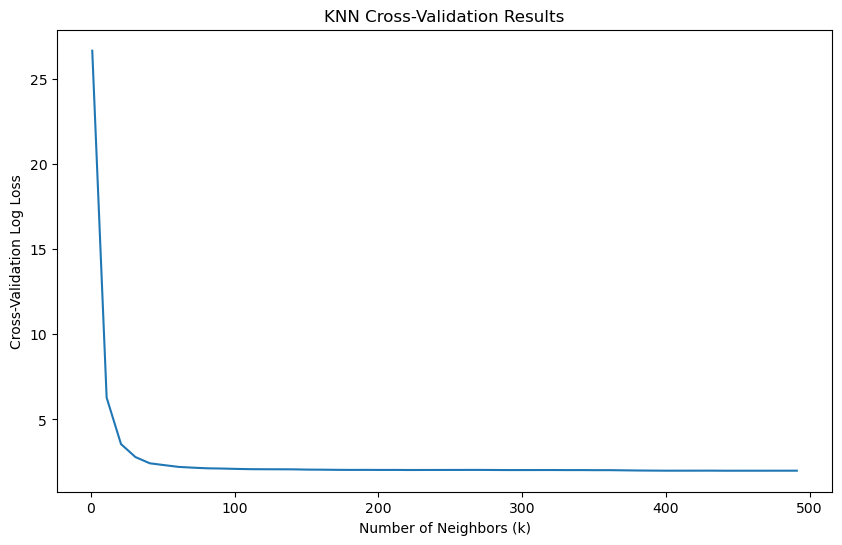

In [13]:
# Find optimal k using cross-validation
k_range = range(1, 501, 10)  # Test k values from 1 to 500 in steps of 10
cv_scores = []

for k in k_range:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = model_selection.cross_val_score(knn, X, y, cv=5, scoring='neg_log_loss')
    cv_scores.append(-scores.mean())  # Negative because we want to minimize log loss

# Find the optimal k
optimal_k = k_range[np.argmin(cv_scores)]

# Train final model with optimal k
knn = neighbors.KNeighborsClassifier(n_neighbors=optimal_k, weights='distance')
probs_knn = knn.fit(X,y).predict_proba(X_test)

probs_knn_smooth = [smooth(i) for i in probs_knn]

# Print results
print(f"Optimal k: {optimal_k}")
#print(f"Log loss (unsmoothed): {metrics.log_loss(y_test, probs_knn)}")
#print(f"Log loss (smoothed): {metrics.log_loss(y_test, probs_knn_smooth)}")

# Optionally plot CV results
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validation Log Loss')
plt.title('KNN Cross-Validation Results')
plt.show()

In [108]:
#print(metrics.log_loss(y_test, probs_knn, labels = [i for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_knn_smooth, labels = [i for i in range(1,11)]))

In [15]:
rf = ensemble.RandomForestClassifier(random_state=42, criterion="log_loss")
probs_rf = rf.fit(X,y).predict_proba(X_test)
probs_rf_smooth = [smooth(i) for i in probs_rf]
#print(metrics.log_loss(y_test, probs_rf, labels = [i for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_rf_smooth, labels = [i for i in range(1,11)]))

random forest with hyperparameter tuning

In [27]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create RandomForest with CV
rf_cv = model_selection.GridSearchCV(
    ensemble.RandomForestClassifier(random_state=42, criterion="log_loss"),
    param_grid=param_grid,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1
)

# Fit and predict
rf_cv.fit(X, y)
probs_rf = rf_cv.predict_proba(X_test)
probs_rf_smooth = [smooth(i) for i in probs_rf]

# Print best parameters and score
print("Best parameters:", rf_cv.best_params_)
#print("Best CV score:", -rf_cv.best_score_)  # Negative because of neg_log_loss

Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}


gradient boosting

In [16]:
gb = ensemble.GradientBoostingClassifier(random_state=42)
probs_gb = gb.fit(X,y).predict_proba(X_test)
probs_gb_smooth = [smooth(i) for i in probs_gb]

# development test set
#print(metrics.log_loss(y_test, probs_gb, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_gb_smooth, labels = ['subjective_poverty_' + str(i) for i in range(1,11)]))

In [17]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Adjust the labels to be 0-based
y_zero_based = y - 1  # Subtract 1 from all labels to make them 0-based

# Parameter distributions (unchanged)
#param_distributions = {
#       'learning_rate': uniform(0.01, 0.3),
#    'max_depth': randint(3, 10),
#    'n_estimators': randint(100, 1000),
#    'reg_alpha': uniform(0, 2),
#    'reg_lambda': uniform(0, 2),
#    'gamma': uniform(0, 5),
#    'subsample': uniform(0.6, 0.4),
#    'colsample_bytree': uniform(0.6, 0.4),
#    'colsample_bylevel': uniform(0.6, 0.4),
#    'min_child_weight': randint(1, 7),
#    'max_delta_step': randint(0, 10),
#    'scale_pos_weight': uniform(0.8, 0.4)
#}

#NEW
param_distributions = {
    'learning_rate': uniform(0.005, 0.095),  # Lower learning rates
    'max_depth': randint(3, 7),  # Reduced max depth range
    'n_estimators': randint(200, 2000),  # More estimators
    'reg_alpha': uniform(0.1, 1.9),  # L1 regularization
    'reg_lambda': uniform(0.1, 1.9),  # L2 regularization
    'gamma': uniform(0.1, 0.9),  # Minimum loss reduction
    'subsample': uniform(0.7, 0.3),  # Slightly higher subsample
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(3, 7),  # Increased min_child_weight
}

# Base model with adjusted num_class
xgb_base = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=10,  # Still 10 classes, but now 0-9
    random_state=42,
    tree_method='hist',
    grow_policy='lossguide'
)

# Random Search with adjusted y values
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_log_loss',
    cv=5,
    verbose=1,
    n_jobs=-1,
    #random_state=42
)

# Fit with adjusted y values
random_search.fit(X, y_zero_based)

# When making predictions, add 1 back to get original scale
probs_xgb = random_search.predict_proba(X_test)
probs_xgb_smooth = [smooth(i) for i in probs_xgb]

# Evaluate using original 1-10 labels
#print("\nFinal model performance:")
#print(f"Log loss (unsmoothed): {metrics.log_loss(y_test, probs_xgb, labels=[i for i in range(1,11)])}")
#print(f"Log loss (smoothed): {metrics.log_loss(y_test, probs_xgb_smooth, labels=[i for i in range(1,11)])}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [111]:
# development test set
#print(metrics.log_loss(y_test, probs_gb, labels = [i for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_gb_smooth, labels = [i for i in range(1,11)]))

In [28]:
stack = ensemble.StackingClassifier([('logistic CV', lr_final), ('knn', knn), ("XGboost", random_search.best_estimator_)])
stack_fit = stack.fit(X,y)
probs_stack = stack_fit.predict_proba(X_test)
probs_stack_smooth = [smooth(i) for i in probs_stack]

# development test set
#print(metrics.log_loss(y_test, probs_stack, labels = [i for i in range(1,11)]))
#print(metrics.log_loss(y_test, probs_stack_smooth, labels = [i for i in range(1,11)]))

#real test set
out_df = pd.DataFrame(index=df_test.index, columns = ['subjective_poverty_' + str(i) for i in range(1,11)], data=probs_stack)

print(len(out_df))
out_df.to_csv("probs_4.csv") # best one is logistic CV, knn, XGboost

1334


In [34]:
stack = ensemble.StackingClassifier([('logistic CV', lr_final), ('knn', knn), ('XGboost',random_search.best_estimator_)])
scores = model_selection.cross_val_score(stack, X, y, cv=5, scoring='neg_log_loss', n_jobs=5)
print(scores)

[-1.74956716 -1.75252509 -1.7474914  -1.77125678 -1.75074781]


In [32]:
print(scores.mean())

-1.7545185329638453


In [ ]:
print(stack_fit.classes_)